# Flights Data Exploration
## by Natalya Bakhshetyan

> This document explores US domestic flight data for years 2017 through 2019. Only January data is used. A random sample of 30,000 flights was analysed, whereas the original data contains about 1.5 million flights.The original dataset was downloaded from http://stat-computing.org/dataexpo/2009/the-data.html.

## Preliminary Wrangling

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

In [2]:
#load the datasets into pandas DataFrames and print their sizes
flight_data1 = pd.read_csv("flight_data1.csv", dtype = {'DEP_TIME': object, 'ARR_TIME': object})
flight_data2 = pd.read_csv("flight_data2.csv", dtype = {'DEP_TIME': object, 'ARR_TIME': object})
flight_data3 = pd.read_csv("flight_data3.csv", dtype = {'DEP_TIME': object, 'ARR_TIME': object})
print(flight_data1.shape, flight_data2.shape, flight_data3.shape)

(450017, 27) (570118, 27) (583985, 27)


In [3]:
# sample 10,000 rows from each DataFrame for our analysis
sample_data1 = flight_data1.sample(n=10000, random_state=1)
sample_data2 = flight_data2.sample(n=10000, random_state=1)
sample_data3 = flight_data3.sample(n=10000, random_state=1)

In [4]:
#combine all 3 DataFrames into 1
combined_df = pd.concat([sample_data1, sample_data2, sample_data3])

In [5]:
# high-level overview of data shape and composition
print(combined_df.shape)
print(combined_df.dtypes)
print(combined_df.columns)
print(combined_df.head())

(30000, 27)
YEAR                     int64
MONTH                    int64
DAY_OF_WEEK              int64
OP_CARRIER_FL_NUM        int64
ORIGIN                  object
ORIGIN_CITY_NAME        object
ORIGIN_STATE_NM         object
DEST                    object
DEST_CITY_NAME          object
DEST_STATE_NM           object
DEP_TIME                object
DEP_DELAY              float64
DEP_DELAY_NEW          float64
DEP_DEL15              float64
DEP_DELAY_GROUP        float64
ARR_TIME                object
CANCELLED              float64
CANCELLATION_CODE       object
DIVERTED               float64
AIR_TIME               float64
DISTANCE               float64
CARRIER_DELAY          float64
WEATHER_DELAY          float64
NAS_DELAY              float64
SECURITY_DELAY         float64
LATE_AIRCRAFT_DELAY    float64
Unnamed: 26            float64
dtype: object
Index(['YEAR', 'MONTH', 'DAY_OF_WEEK', 'OP_CARRIER_FL_NUM', 'ORIGIN',
       'ORIGIN_CITY_NAME', 'ORIGIN_STATE_NM', 'DEST', 'DEST_CITY_NA

In [6]:
#convert DAY_OF_WEEK to ordered categorical
def to_categorical(col, ordered_categories):
    ordered_var = pd.api.types.CategoricalDtype(ordered = True, categories = ordered_categories)
    combined_df[col] = combined_df[col].astype(ordered_var)

col = "DAY_OF_WEEK"
ordered_categories = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', "Saturday", 'Sunday']
combined_df[col] = combined_df[col].astype(str)
weekday_dict = {'1': 'Monday', '2' : "Tuesday", '3': 'Wednesday',
               '4': 'Thursday', '5': 'Friday', '6': 'Saturday',
               '7': 'Sunday'}
combined_df[col] = combined_df[col].replace(weekday_dict)
to_categorical(col, ordered_categories)

In [7]:
#confirm conversion of DAY_OF_WEEK to ordered categorical
combined_df.DAY_OF_WEEK.unique()

[Monday, Saturday, Thursday, Wednesday, Sunday, Tuesday, Friday]
Categories (7, object): [Monday < Tuesday < Wednesday < Thursday < Friday < Saturday < Sunday]

In [8]:
#convert DEP_DEL15 to string and confirm the conversion
combined_df['DEP_DEL15'] = combined_df['DEP_DEL15'].astype(str)
combined_df['DEP_DEL15'].unique()

array(['1.0', '0.0', 'nan'], dtype=object)

In [9]:
# rename DEP_DEL15 values to make them descriptive and confirm the renaming
delay_dict = {'0.0': '< 15 min', '1.0' : ">= 15 min"}
combined_df['DEP_DEL15'] = combined_df['DEP_DEL15'].replace(delay_dict)
combined_df['DEP_DEL15'].unique()

array(['>= 15 min', '< 15 min', 'nan'], dtype=object)

In [10]:
#convert CANCELLATION_CODE to it's meaning and confirm the conversion
col = "CANCELLATION_CODE"
cancellation_code_dict = {'A': 'carrier', 'B' : "weather", 'C': 'NAS',
               'D': 'security'}
combined_df[col] = combined_df[col].replace(cancellation_code_dict)
combined_df.CANCELLATION_CODE.unique()

array([nan, 'carrier', 'weather', 'NAS', 'security'], dtype=object)

In [11]:
#Convert DEP_TIME and ARR_TIME from string to datetime.time and confirm conversion
def float_to_datetime(col):    
    combined_df[col] = pd.to_datetime(combined_df[col], format='%H%M', errors = 'coerce').dt.time
    
float_to_datetime('DEP_TIME')
float_to_datetime('ARR_TIME')
print(combined_df.DEP_TIME.head())
print(combined_df.ARR_TIME.head())

217132    19:26:00
188169    07:22:00
159183    11:01:00
281252    06:58:00
200261    14:52:00
Name: DEP_TIME, dtype: object
217132    21:58:00
188169    07:28:00
159183    17:27:00
281252    11:54:00
200261    17:48:00
Name: ARR_TIME, dtype: object


### Dataset Structure

There are 30,000 US domestic flights in the cleaned data set from months of January from years 2017, 2018 and 2019. 

**Variable description**

- YEAR: 2017, 2018 or 2019; eg: 2017
- MONTH: 1, which stands for January; eg: 1
- DAY_OF_WEEK: Monday-Sunday; eg: Tuesday
- OP_CARRIER_FL_NUM: flight number; eg: 2186
- ORIGIN: origin airport name; eg: DFW
- ORIGIN_CITY_NAME: origin city name and state; eg: Dallas/Fort Worth, TX
- ORIGIN_STATE_NM: origin state name; eg: Texas
- DEST: destination airport; eg: JFK
- DEST_CITY_NAME: destination city name and state; eg: Palm Springs, CA
- DEST_STATE_NM: destination state name; eg: California
- DEP_DELAY: difference in minutes between scheduled and actual departure time, early departures show negative numbers; eg: -3
- DEP_DELAY_NEW: difference in minutes between scheduled and actual departure time, early departures set to 0; eg: 3
- DEP_DEL15: departure delay indicator, 15 minutes or more versus less than 15 minutes; eg: >= 15 min
- DEP_DELAY_GROUP: departure delay intervals, every (15 minutes from <-15 to >180); eg: -1
- ARR_TIME: arrival time; eg: 19:26:00
- CANCELLED: whether the flight is cancelled or no, 1.0 = cancelled; eg: 1.0
- CANCELLATION_CODE: cancellation reason; eg: weather delay
- DIVERTED: whether the flight diverted or no, 1.0 = diverted; eg: 1.0
- AIR_TIME: flight time in minutes; eg: 160.0
- DISTANCE: flight distance in miles; eg: 1126.0
- CARRIER_DELAY: carrier delay in minutes; eg: 1.0
- WEATHER_DELAY: weather delay in minutes; eg: 15.0
- NAS_DELAY: NAS delay in minutes; eg: 2.0
- SECURITY_DELAY: security delay in minutes; eg: 30.0
- LATE_AIRCRAFT_DELAY: late aircraft delay in minutes; eg: 5.0


### Main features of interest in the dataset

> For the most part this exploration will focus on delays/cancellations/divertions and their reasons compared between different airports.

### Variables in the dataset, which will help support the investigation of the features of interest

> ORIGIN, DEP_DELAY_NEW, DEP_DEL15, CANCELLED, CANCELLATION_CODE, DIVERTED, CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY

## Univariate Exploration

> We will first look at the distribution of different variables in our dataset. Bear in mind that the distribution counts are not absolute, since we are exploring a sample data.

1. Distribution of flights by days of week.

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

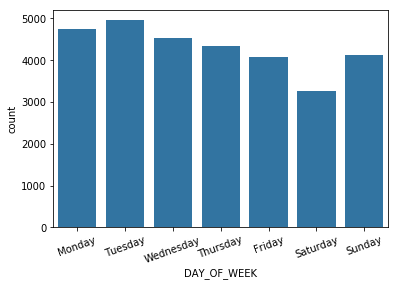

In [12]:
default_color = sb.color_palette()[0]
sb.countplot(data = combined_df, x = 'DAY_OF_WEEK', color = default_color)
plt.xticks(rotation=20)

In contrary to my expectation to see an even distribution of flights throughout the week, there are actually much less flighst on Saturdays compared to other days of the week.

2. Top destination states.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51]), <a list of 52 Text xticklabel objects>)

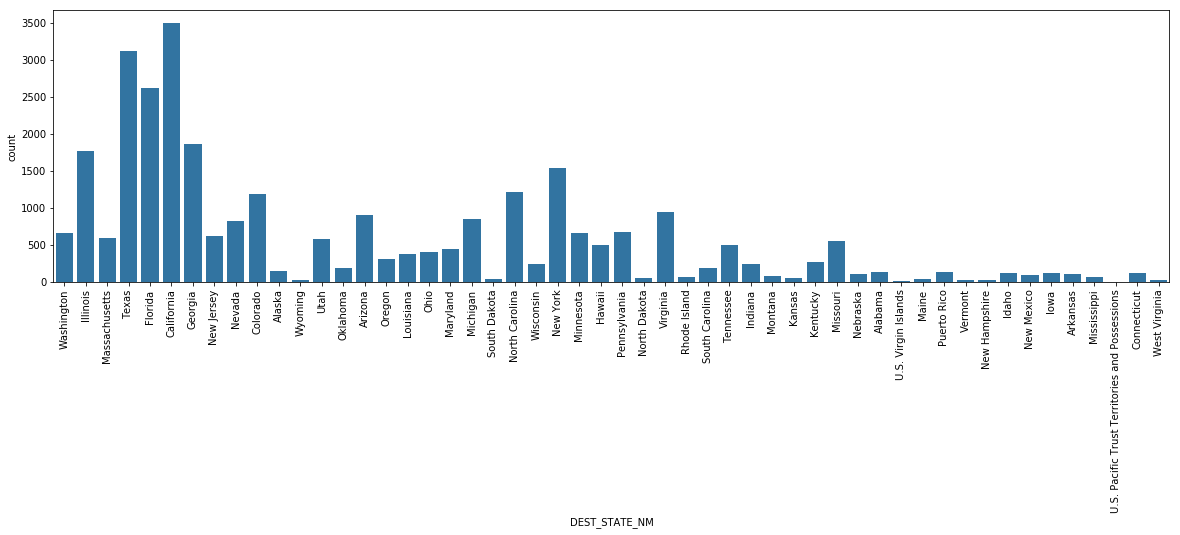

In [13]:
default_color = sb.color_palette()[0]
plt.figure(figsize = [20,5])
sb.countplot(data = combined_df, x = 'DEST_STATE_NM', color = default_color)
plt.xticks(rotation=90)

Top 3 destination states are Texas, Florida and California.

3. Distribution of departing flights based on hour of the day.

/home/nata/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/nata/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


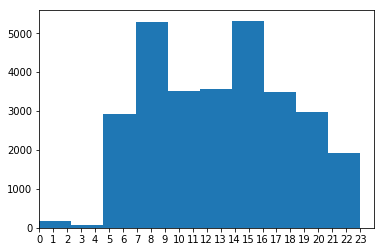

In [14]:
def chart(occurance_list):
    hour_list = [t.hour for t in occurance_list]
    numbers=[x for x in range(0,24)]
    labels=map(lambda x: str(x), numbers)
    plt.xticks(numbers, labels)
    plt.xlim(0,24)
    plt.hist(hour_list)
    plt.show()

    
chart(combined_df['DEP_TIME'])    

Peak amount of flights occur early in the morning and late in the afternoon and there are minimal flights at night.

4. Distribution of departing flights based on hour of the day for years 2017, 2018 and 2019 depicted on separate plots.

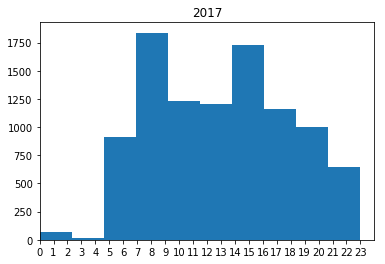

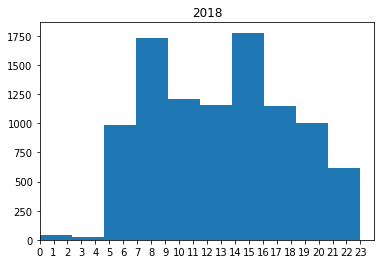

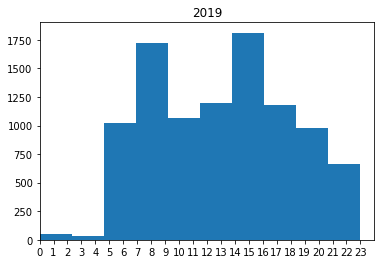

In [15]:
flights_2017 = combined_df[combined_df['YEAR'] == 2017]
flights_2018 = combined_df[combined_df['YEAR'] == 2018]
flights_2019 = combined_df[combined_df['YEAR'] == 2019]  
plt.title('2017')
chart(flights_2017['DEP_TIME'])
plt.title('2018')
chart(flights_2018['DEP_TIME']) 
plt.title('2019')
chart(flights_2019['DEP_TIME'])    

We can observe on the plots above that departure times have stayed overall consistent throughout those years with very slight changes.

5. Distribution of flight durations on a standard-scaled plot.

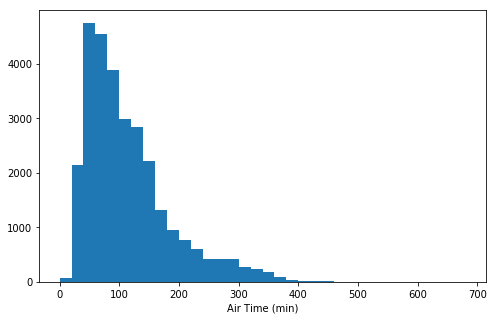

In [16]:
binsize = 20
bins = np.arange(0, combined_df['AIR_TIME'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = combined_df, x = 'AIR_TIME', bins = bins)
plt.xlabel('Air Time (min)')
plt.show()

Air time has a long-tailed distribution, with a lot of flights around 100 minute-long and fewer flights greater than 200 minute-long.

6. Distribution of flight durations on a log-scaled plot.

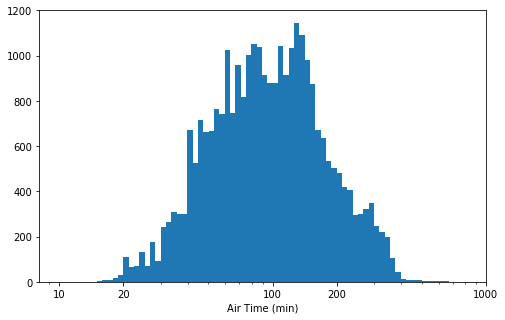

In [17]:
log_binsize = 0.025
bins = 10 ** np.arange(1, np.log10(combined_df['AIR_TIME'].max())+log_binsize, log_binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = combined_df, x = 'AIR_TIME', bins = bins)
plt.xscale('log')
plt.xticks([10, 20, 100, 200, 1000], ['10', '20', '100', '200', '1000'])
plt.xlabel('Air Time (min)')
plt.show()

The log scaled plot of air time reveals two significant peaks: one at around 80 minutes and the other around 120 minutes.

7. Distribution of departure delay times on a standard-scaled plot.

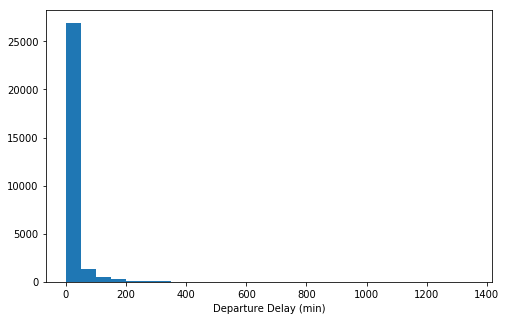

In [18]:
binsize = 50
bins = np.arange(0, combined_df['DEP_DELAY_NEW'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = combined_df, x = 'DEP_DELAY_NEW', bins = bins)
plt.xlabel('Departure Delay (min)')
plt.show()

Again we have a long-talied distribution, where a lot of delays are less than 100 minute-long.

8. Distribution of departure delay times on a log-scaled plot.

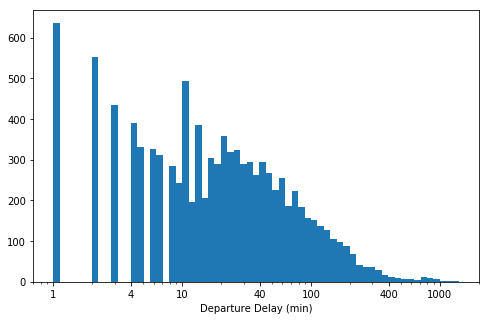

In [19]:
log_binsize = 0.05
bins = 10 ** np.arange(0, np.log10(combined_df['DEP_DELAY_NEW'].max())+log_binsize, log_binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = combined_df, x = 'DEP_DELAY_NEW', bins = bins)
plt.xscale('log')
plt.xticks([1, 4, 10, 40, 100, 400, 1000], ['1', '4','10', '40', '100', '400', '1000'])
plt.xlabel('Departure Delay (min)')
plt.show()

On a log-scaled plot, we can more clearly observe the distrubution of delays. 

9. Distribution of flight distances on a standard-scaled plot.

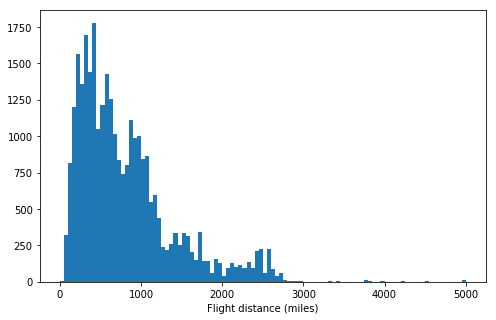

In [20]:
binsize = 50
bins = np.arange(0, combined_df['DISTANCE'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = combined_df, x = 'DISTANCE', bins = bins)
plt.xlabel('Flight distance (miles)')
plt.show()

There are multiple peaks in the distribution, with the most significant one at around 3000, 6000 and 9000 miles.

### Discussion

1. On weakends, especially Saturdays, there are fewer flights than on other days of the week.
2. Top 3 destination states are California, Texas and Florida.
3. There are minimal amount of flights between 1 am and 4am, with a lot of flights occuring early in the morning and late in the afternoon.
4. In the years 2017, 2018 and 2019 flight distribution throughout the day has remained about the same.
5. A lot of flights are about 100 minutes in duration.
6. Since there was a long tail on the previous graph with standard scale, a log-scaled graph was produced to better visualize the distribution of flights with longer durations. The log scaled plot of air time reveals two significant peaks: one at around 80 minutes and the other around 120 minutes.
7. A lot of delays are less than 100 minute-long.
8. Since there was a long tail on the previous graph with standard scale, a log-scaled graph was produced to better visualize the distribution of flights with longer delays.
9. There are multiple peaks in the distribution of flight distances, with the most significant ones at around 3000, 6000 and 9000 miles.

## Bivariate Exploration

Below is a heatmap of correlations between numeric type data, which we need to look at first to see whether there are any interesting correlations that we will want to explore further in our analysis. The strongest correlation is between air time and flight distance, which makes sense. There are also different amounts of correlations between delay reasons and overall departure delay, which also makes sense, since each separate delay reason contributes to overall delay. From this information we can say that late aircraft delay contributes the most to departure delays.

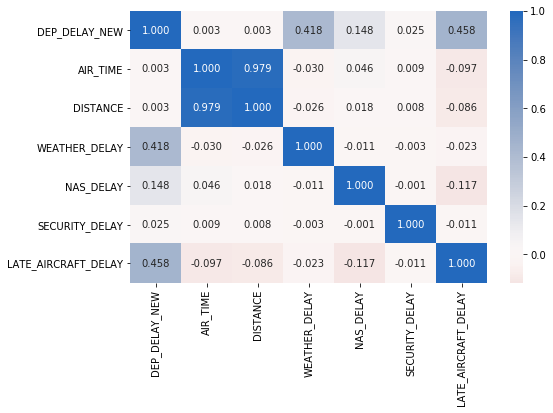

In [21]:
#correlation plot

numeric_vars = ['DEP_DELAY_NEW', 'AIR_TIME', 'DISTANCE', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']
plt.figure(figsize = [8, 5])
sb.heatmap(combined_df[numeric_vars].corr(), annot = True, fmt = '.3f',
           cmap = 'vlag_r', center = 0)
plt.show()

Now, let's explore whether some airports are home to longer delays compared to others. Since there are about 330 different airports in the database, we will only look at the top 5 busiest ones. The first 3 airports have more longer delays than the last 2 airports.

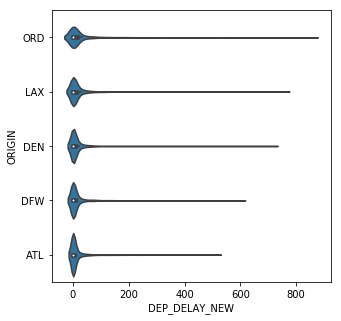

In [22]:
# get the list of top 5 busiest airports from the dataset.
top_5_origin = combined_df['ORIGIN'].value_counts().head(5).keys()
#create a dataframe with top 5 airports
top_5_origin_df = combined_df[combined_df['ORIGIN'].isin(top_5_origin)]
#order origins based on mean departure delay
my_order = top_5_origin_df.groupby(by=['ORIGIN'])['DEP_DELAY_NEW'].mean().sort_values(ascending=False).index
#create violinplot with order based on ascending mean departure delay
default_color = sb.color_palette()[0]
plt.figure(figsize = [5,5])
sb.violinplot(data = top_5_origin_df, y= 'ORIGIN', x= 'DEP_DELAY_NEW', color= default_color, order= my_order)

Now, let's create a similar plot to above, but this time we will exclude any flights with no delays.

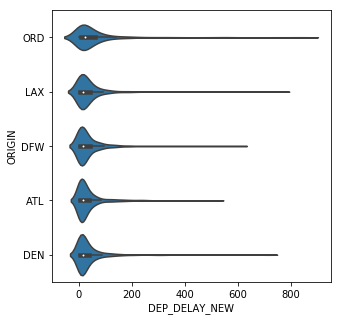

In [23]:
# get the list of top 5 airports from the dataset.
top_5_origin = combined_df['ORIGIN'].value_counts().head(5).keys()
#create a dataframe with top 5 airports, including fligths with delays only
top_5_origin_df = combined_df[combined_df['ORIGIN'].isin(top_5_origin) & combined_df['DEP_DELAY_NEW'] > 0]
#order origins based on mean departure delay
my_order = top_5_origin_df.groupby(by=['ORIGIN'])['DEP_DELAY_NEW'].mean().sort_values(ascending=False).index
#create violinplot with order based on ascending mean duration delay
default_color = sb.color_palette()[0]
plt.figure(figsize = [5,5])
sb.violinplot(data = top_5_origin_df, y= 'ORIGIN', x= 'DEP_DELAY_NEW', color= default_color, order= my_order)

Let's now take a look at the distribution of different delay types for the top 5 busiest airports. Just by looking at the ammount of data points on each plot, we can say that late aircraft delay is the most frequent delay reason. The least frequent delay reason is security delay. Actually, in this particular sample, there are only 2 security delay incidents, both of which are in LAX. Not suprisingly, LAX has fewer and shorter weather delays compared to other airports, but surprisingly DEN has about the same weather delay distribution as LAX. This is unusual, since Denver is located in a cold place, where it snows in the winter like in Atlanta (ATL) and Chicago (ORD). DFW weather delay distribution is for the most part similar to LAX, with just one 200+ minute delay. NAS delays are fewer and shorter in LAX and DFW. Carreier delays are fewer and shorter in DEN.

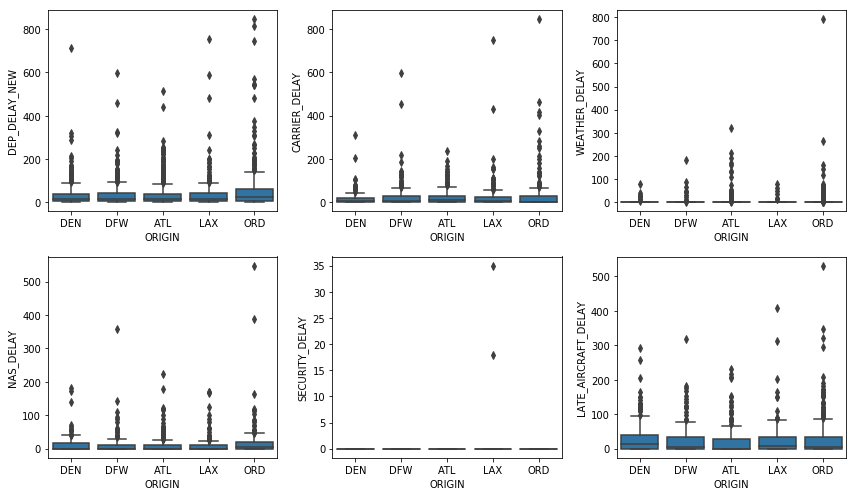

In [25]:
yvars = ['DEP_DELAY_NEW', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY',
         'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']

plt.subplots(2,3,figsize=(12,7))
count = 1
default_color = sb.color_palette()[0]
for yvar in yvars:
    plt.subplot(2,3, count)
    sb.boxplot(x= "ORIGIN", y=yvar, data=top_5_origin_df, color= default_color)
    plt.xlabel('ORIGIN')
    plt.ylabel(yvar)
    plt.tight_layout()
    count +=1

It is interesting to observe how flights with some destinations have higher divertion rates as depicted on the plot below. MDW is located in Chicago, and given that we are dealing with January data, it is not surprising to see that this destination airport has a high divertion rate. SAN is in San Diego. Although San Diego is an all-year-round sunny city, it is listed along with LGA in the top 10 challenging airports in the USA according to this article: https://www.honeywell.com/en-us/newsroom/news/2017/03/the-10-most-challenging-airports-in-the-us

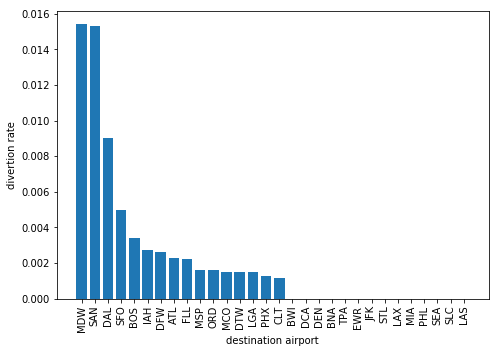

In [28]:
# get the list of top 30 destination airports from the database.
top_30_dest = combined_df['DEST'].value_counts().head(30).keys()
#create a dataframe with top 30 destination airports
top_30_dest_df = combined_df[combined_df['DEST'].isin(top_30_dest)]
#order destinations based on mean divertions
my_order = top_30_dest_df.groupby(by=['DEST'])['DIVERTED'].mean().sort_values(ascending=False)
# plot the barchart
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
dest = my_order.index
mean_diverted = my_order
ax.bar(dest,mean_diverted)
plt.xticks(rotation = 90)
plt.xlabel('destination airport')
plt.ylabel('divertion rate')
plt.show()

Let's now look at which airporst have more cancellations. Again, we will consider only the top 30 origins for our analysis. MDW has about 7 times more frequent cancellations than MIA. MDW had a very high divertion rate also as depicted in the plot above. Again, this may be due to particularly bad weather conditions, since the airport is located in the snowy city of Chicago. ORD is also located in Chicago, so it is not surprising that it has the second highest cancellation rate on this plot. The next 2 airports with the highest cancellation rates are JFK and BOS, which are both located in cities with cold climate, where there is a lot of snow in January. Overall, there are more airports located in colder cities on the left side of the plot and more airports located in warmer cities on the right side of the plot.

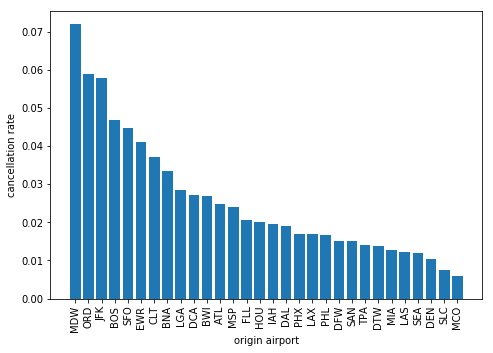

In [29]:
# get the list of top 30 airports from the database.
top_30_origin = combined_df['ORIGIN'].value_counts().head(30).keys()
#create a dataframe with top 30 airports
top_30_origin_df = combined_df[combined_df['ORIGIN'].isin(top_30_origin)]
#order origins based on mean cancellations
my_order = top_30_origin_df.groupby(by=['ORIGIN'])['CANCELLED'].mean().sort_values(ascending=False)
# plot the barchart
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
origin = my_order.index
mean_cancellation = my_order
ax.bar(origin,mean_cancellation)
plt.xticks(rotation = 90)
plt.xlabel('origin airport')
plt.ylabel('cancellation rate')
plt.show()

Thursdays have higher cancellation rate compared to all other days. This is suprising to observe as it would be expected to have about the same cancellation rate throughout the week.

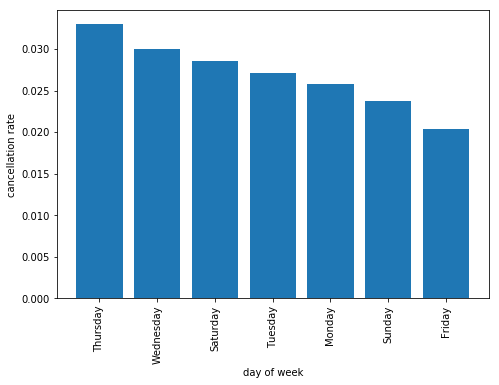

In [30]:
#order days of weak based on mean cancellations
my_order = combined_df.groupby(by=['DAY_OF_WEEK'])['CANCELLED'].mean().sort_values(ascending=False)
# plot the barchart
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
origin = my_order.index
mean_canellation = my_order
ax.bar(origin,mean_canellation)
plt.xticks(rotation = 90)
plt.xlabel('day of week')
plt.ylabel('cancellation rate')
plt.show()

## Multivariate Exploration

In [31]:
# get the list of top 10 busiest origin airports from the database.
top_10_origin = combined_df['ORIGIN'].value_counts().head(10).keys()

#create a dataframe with top 10 busiest origin airports
top_10_origin_df = combined_df[combined_df['ORIGIN'].isin(top_10_origin)]

list(top_10_origin)

['ATL', 'ORD', 'DFW', 'DEN', 'LAX', 'CLT', 'PHX', 'SFO', 'LAS', 'IAH']

In [32]:
def cancellation_code_rate(airport, cancellation_code):
    code_occurence = top_10_origin_df[(top_10_origin_df['ORIGIN'] == airport) & (top_10_origin_df['CANCELLATION_CODE'] == cancellation_code)].shape[0]
    return (code_occurence/top_10_origin_df.shape[0])

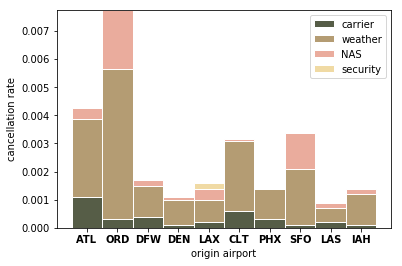

In [33]:
# Values of each group
bars1 = [cancellation_code_rate(airport, 'carrier') for airport in top_10_origin]
bars2 = [cancellation_code_rate(airport, 'weather') for airport in top_10_origin]
bars3 = [cancellation_code_rate(airport, 'NAS') for airport in top_10_origin]
bars4 = [cancellation_code_rate(airport, 'security') for airport in top_10_origin]

#cancellation reasons
cancellation_reasons = ['carrier', 'weather', 'NAS', 'security']

# Heights of bars1 + bars2
bars12 = np.add(bars1, bars2).tolist()

# Heights of bars1 + bars2 + bars3
bars123 = np.add(bars12, bars3).tolist()
 
# The position of the bars on the x-axis
r = [0,1,2,3,4,5,6,7,8,9]
 
# Names of group and bar width
names = list(top_10_origin)
barWidth = 1
 
# Create green bars
plt.bar(r, bars1, color='#565d47', edgecolor='white', width=barWidth)
# Create brown bars
plt.bar(r, bars2, bottom=bars1, color='#b49c73', edgecolor='white', width=barWidth)
# Create pink bars
plt.bar(r, bars3, bottom=bars12, color='#eaac9d', edgecolor='white', width=barWidth)
# Create yellow bars
plt.bar(r, bars4, bottom=bars123, color='#f0daa4', edgecolor='white', width=barWidth)
 
# axis, title, legend
plt.xticks(r, names, fontweight='bold')
plt.xlabel("origin airport")
plt.ylabel('cancellation rate')
plt.legend(cancellation_reasons) 

# Show graphic
plt.show()


The above plot helps to visualize how much each cancellation reason contributes to overall cancellations for the top 10 busiest airports. Clearly, the most predominant cancellation reason for all airports is weather. The proportion of NAS and carrier delays is more variable between airports. PHX has no NAS cancellations at all, whereas there are way more NAS cancellations than carrier cancellations in ORD and SFO. Cancellations due to security are only present in LAX. In previous plots, we saw that delays due to security reasons are also unique to LAX.

In [34]:
combined_df['DEP_DELAY_GROUP'].unique()

array([ 7., -1.,  5., 12.,  0.,  3.,  2.,  1., -2., nan,  8.,  6.,  4.,
       11.,  9., 10.])

Text(0.5, 0, 'Origin Airport')

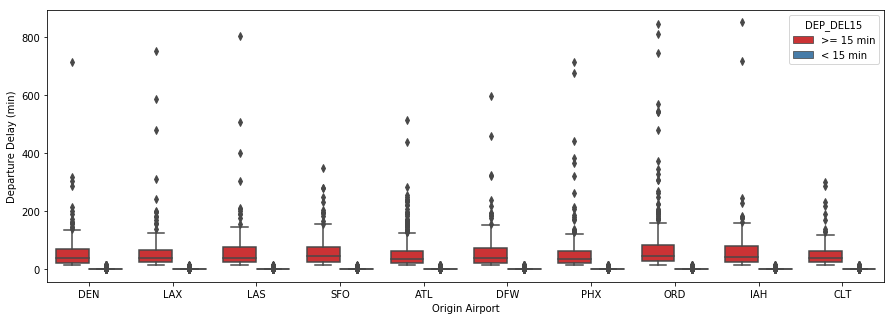

In [35]:
# Grouped boxplot
filtered_data = top_10_origin_df[top_10_origin_df['DEP_DEL15'] != 'nan']    
plt.figure(figsize=(15,5))
sb.boxplot(x= "ORIGIN", y="DEP_DELAY_NEW", hue = "DEP_DEL15", data=filtered_data, palette = 'Set1')
plt.ylabel('Departure Delay (min)')
plt.xlabel('Origin Airport')

As depicted in the plots of departure delay distribution in bivariate exploration, a lot of delays are very short. The plot above helps to separate delays that are greater or equal to 15 to be able to look more closely on the distribution of longer delays. Here we can clearly see that the distrubution of delays less than 15 minutes in time is almost the same for all 10 airports. The picture is completely different with longer delays. If we look at the points outside of the boxes, there are some very long delays above 400 minutes in DEN, LAX, LAS, ATL, DFW, PHX, ORD and IAH. DEN, SFO and CLT do not exceed 400 minutes. When we look at the distribution of points within the red boxes, clearly ORD is the airport with the longest delays among the 10 airports, whereas CLT has the shortest delays among the 10.

> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!